#Quantifying irregularity
Last updated: 22/11/2025

To compute the phase irregulaity of two independent AR processes and see how they behave.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sg


def generate_ar(phi, n, c=0, sigma=1, seed=None):
    rng = np.random.default_rng(seed)
    p = len(phi)
    x = np.zeros(n)
    eps = rng.normal(0, sigma, n)  # white noise

    x[:p] = rng.normal(0, sigma, p)

    for t in range(p, n):
        x[t] = c + np.dot(phi, x[t - np.arange(1, p+1)]) + eps[t]

    return x

# Sampling settings (consistent everywhere)
fs = 200            # Hz
T  = 60             # seconds (longer = more stable estimates)
n  = T * fs         # samples
t  = np.arange(n) / fs

s = np.random.randint(1, 41)
x1 = generate_ar([0.4, -0.7], 1000, seed=s)
x2 = generate_ar([0.1, -0.3], 1000, seed=s+1)

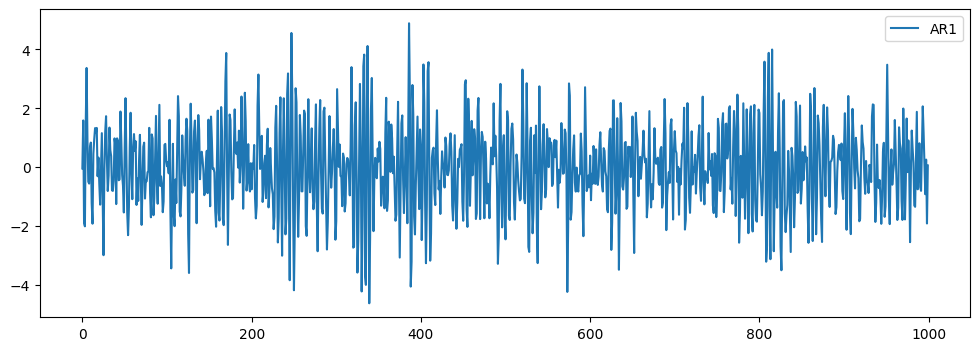

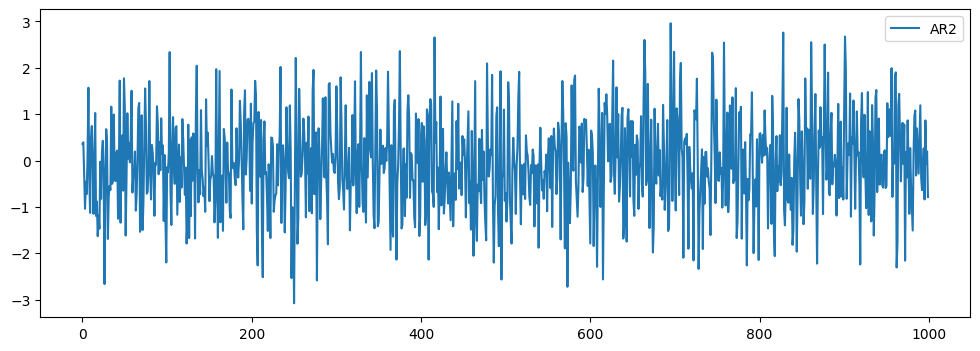

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(x1, label='AR1')
plt.legend()
plt.show()


plt.figure(figsize=(12,4))
plt.plot(x2, label='AR2')
plt.legend()
plt.show()

Once we have the two AR processes, we compute they MPC.



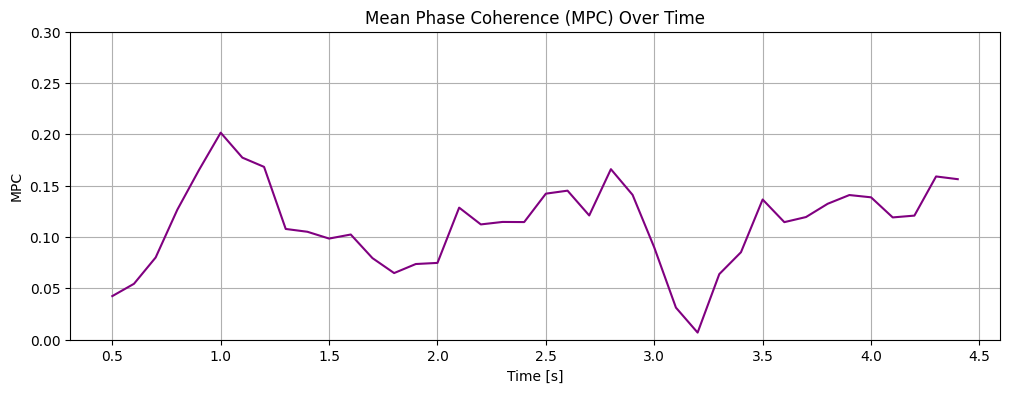

In [ ]:
from scipy.signal import hilbert

window_size = 200
step_size = 20

phase_x1 = np.angle(hilbert(x1))
phase_x2 = np.angle(hilbert(x2))

mpc_values = []
time_points = []

for start in range(0, len(x1) - window_size, step_size):
    end = start + window_size
    phase_diff = phase_x1[start:end] - phase_x2[start:end]
    mpc = np.abs(np.mean(np.exp(1j * phase_diff)))
    mpc_values.append(mpc)
    time_points.append((start + end) / 2 / fs)

mpc_values = np.array(mpc_values)
time_points = np.array(time_points)

plt.figure(figsize=(12, 4))
plt.plot(time_points, mpc_values, color='purple')
plt.title('Mean Phase Coherence (MPC) Over Time')
plt.xlabel('Time [s]')
plt.ylabel('MPC')
plt.ylim([0, 0.3])
plt.grid(True)
plt.show()

Compute surrogate data both:
- in the time domain, and
- directly in the Hilbert domain,

to test how instantaneous amplitude affects the phase estimates.

In [ ]:
#Not a good version because it does not take into account how the imaginary and the real part are created
def time_domain_surrogate(x, seed=None):
    rng = np.random.default_rng(seed)
    Xf = np.fft.rfft(x)
    random_phase = np.exp(1j * rng.uniform(0, 2*np.pi, len(Xf)))
    Xf_surrogate = np.abs(Xf) * random_phase
    x_surrogate = np.fft.irfft(Xf_surrogate, n=len(x))
    return x_surrogate

x1_surrogate = time_domain_surrogate(x1, seed=42)
x2_surrogate = time_domain_surrogate(x2, seed=42)

phase_x1_sur = np.angle(hilbert(x1_surrogate))
phase_x2_sur = np.angle(hilbert(x2_surrogate))

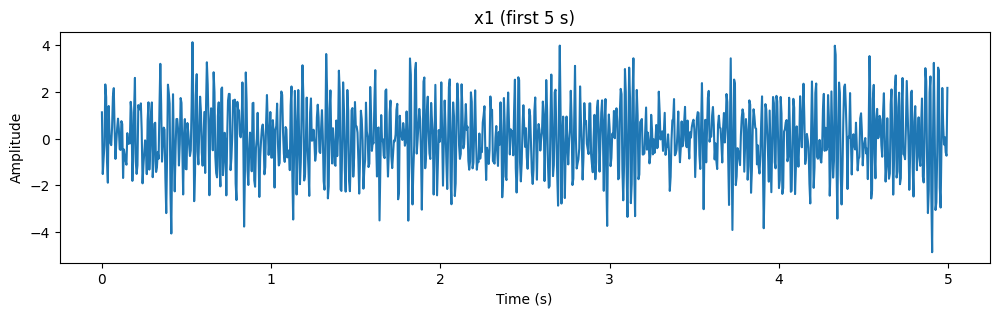

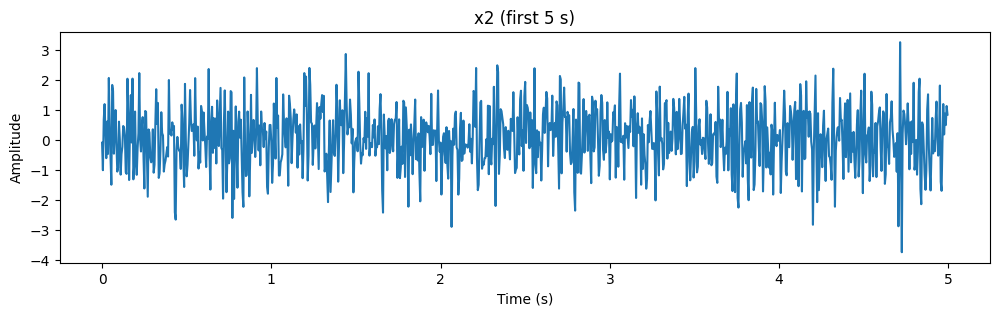

In [ ]:
def time_domain_surrogate_good(x, seed= None):
    rng = np.random.default_rng(seed)
    Xf = np.fft.fft(x)
    N = len(Xf)

    half = N // 2
    random_phase = np.exp(1j * rng.uniform(0, 2*np.pi, half - 1))

    Xf_sur = np.zeros_like(Xf, dtype=complex)

    Xf_sur[0] = np.abs(Xf[0])

    Xf_sur[1:half] = np.abs(Xf[1:half]) * random_phase

    if N % 2 == 0:
        Xf_sur[half] = np.abs(Xf[half])
        Xf_sur[half+1:] = np.conj(Xf_sur[1:half][::-1])
    else:
        Xf_sur[half+1:] = np.conj(Xf_sur[1:half+1][::-1])

    x_surrogate = np.fft.ifft(Xf_sur).real

    return x_surrogate


x1_surrogate = time_domain_surrogate_good(x1)
x2_surrogate = time_domain_surrogate_good(x2)

m = min(len(t), len(x1_surrogate), len(x2_surrogate))

plt.figure(figsize=(12,3))
plt.plot(t[:m], x1_surrogate[:m]); plt.title('x1 (first 5 s)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()

plt.figure(figsize=(12,3))
plt.plot(t[:m], x2_surrogate[:m]); plt.title('x2 (first 5 s)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()

phase_x1_sur = np.angle(hilbert(x1_surrogate))
phase_x2_sur = np.angle(hilbert(x2_surrogate))

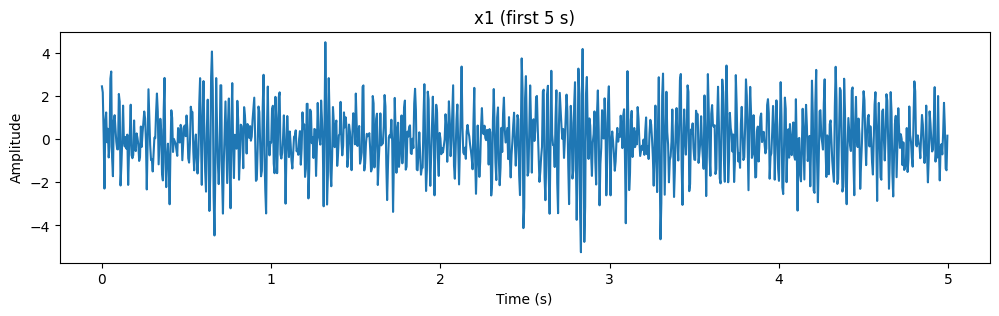

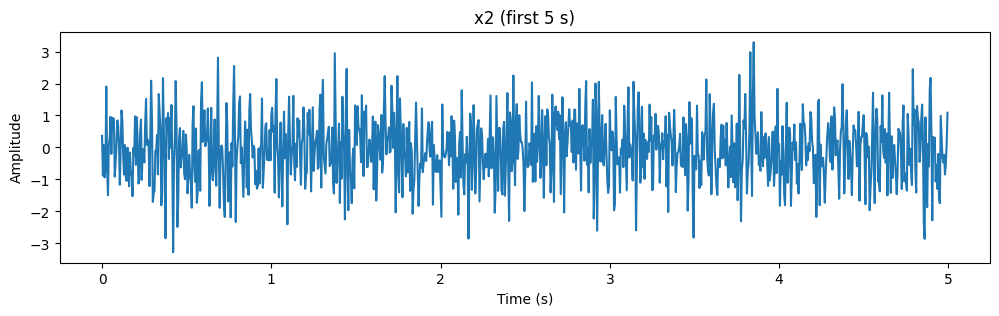

In [ ]:
def time_domain_surrogate_good2(x, seed=None):
    rng = np.random.default_rng(seed)
    Xf = np.fft.fft(x)
    N = len(Xf)

    half = N // 2

    random_phase_angles = rng.uniform(0, 2 * np.pi, half - 1)
    random_phase = np.exp(1j * random_phase_angles)                         #does this line affect to the creation of surrogates???

    Xf_sur = np.zeros_like(Xf, dtype=complex)
    Xf_sur[0] = Xf[0]

    Xf_sur[1:half] = np.abs(Xf[1:half]) * random_phase

    if N % 2 == 0:
        Xf_sur[half] = Xf[half]
        Xf_sur[half+1:] = np.conj(Xf_sur[1:half][::-1])
    else:
        Xf_sur[half+1:] = np.conj(Xf_sur[1:half+1][::-1])

    x_surrogate = np.fft.ifft(Xf_sur).real

    return x_surrogate

x1_surrogate = time_domain_surrogate_good2(x1)
x2_surrogate = time_domain_surrogate_good2(x2)

m = min(len(t), len(x1_surrogate), len(x2_surrogate))

plt.figure(figsize=(12,3))
plt.plot(t[:m], x1_surrogate[:m]); plt.title('x1 (first 5 s)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()

plt.figure(figsize=(12,3))
plt.plot(t[:m], x2_surrogate[:m]); plt.title('x2 (first 5 s)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()

phase_x1_sur = np.angle(hilbert(x1_surrogate))
phase_x2_sur = np.angle(hilbert(x2_surrogate))

In [ ]:
def hilbert_domain_surrogate(x, seed=None):
    rng = np.random.default_rng(seed)
    analytic = hilbert(x)
    amplitude = np.abs(analytic)
    phase = np.angle(analytic)

    amplitude_sur = rng.permutation(amplitude)

    x_surrogate = amplitude_sur * np.cos(phase)
    return x_surrogate

x1_hilbert_sur = hilbert_domain_surrogate(x1, seed=42)
x2_hilbert_sur = hilbert_domain_surrogate(x2, seed=42)

phase_x1_hilbert = np.angle(hilbert(x1_hilbert_sur))
phase_x2_hilbert = np.angle(hilbert(x2_hilbert_sur))


In [ ]:
def compute_mpc(phase1, phase2):
    phase_diff = phase1 - phase2
    return np.abs(np.mean(np.exp(1j * phase_diff)))

mpc_original = compute_mpc(np.angle((x1)), np.angle((x2)))
mpc_time_sur = compute_mpc(phase_x1_sur, phase_x2_sur)
#mpc_hilbert_sur = compute_mpc(np.angle(x1_surrogate), x1_surrogate)

print(f"MPC Original: {mpc_original:.4f}")
print(f"MPC Time-domain Surrogate: {mpc_time_sur:.4f}")
#print(f"MPC Hilbert-domain Surrogate: {mpc_hilbert_sur:.4f}")


MPC Original: 0.0040
MPC Time-domain Surrogate: 0.0364


Let's try again using band-pass filters:

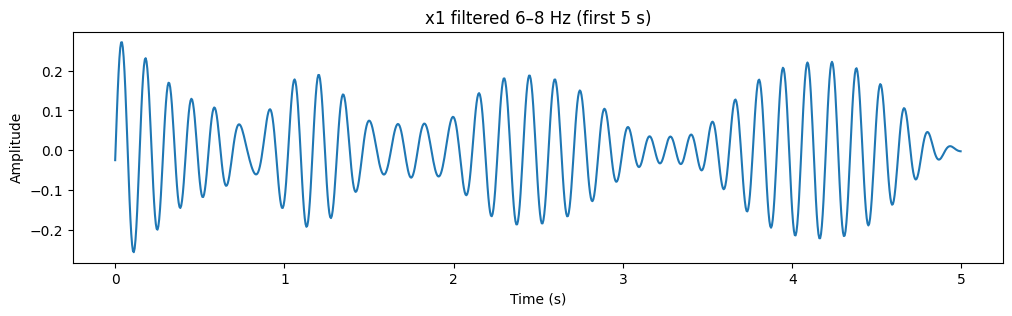

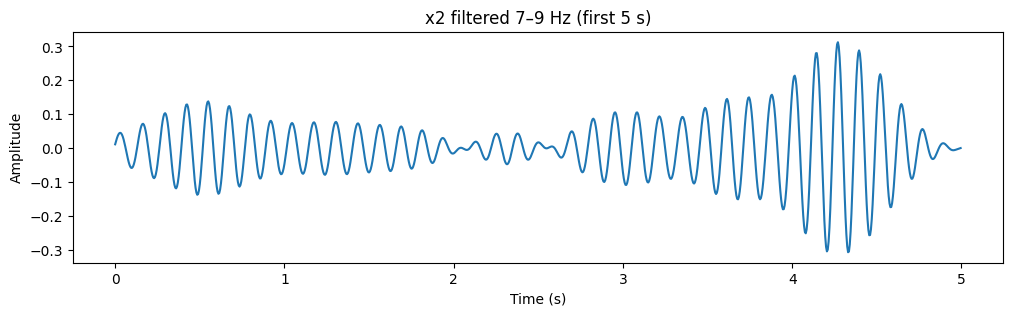

In [ ]:
# Build the two band-pass filters (zero-phase)
sos_bp_68 = sg.butter(N=4, Wn=[6, 8], btype='bandpass', fs=fs, output='sos')
sos_bp_79 = sg.butter(N=4, Wn=[7, 9], btype='bandpass', fs=fs, output='sos')

# Apply them
x1_68 = sg.sosfiltfilt(sos_bp_68, x1)
x2_79 = sg.sosfiltfilt(sos_bp_79, x2)

m = min(len(t), len(x1_68), len(x2_79))


# Quick look at the first 5 seconds
plt.figure(figsize=(12,3))
plt.plot(t[:m], x1_68[:m]); plt.title('x1 filtered 6–8 Hz (first 5 s)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()

plt.figure(figsize=(12,3))
plt.plot(t[:m], x2_79[:m]); plt.title('x2 filtered 7–9 Hz (first 5 s)')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()

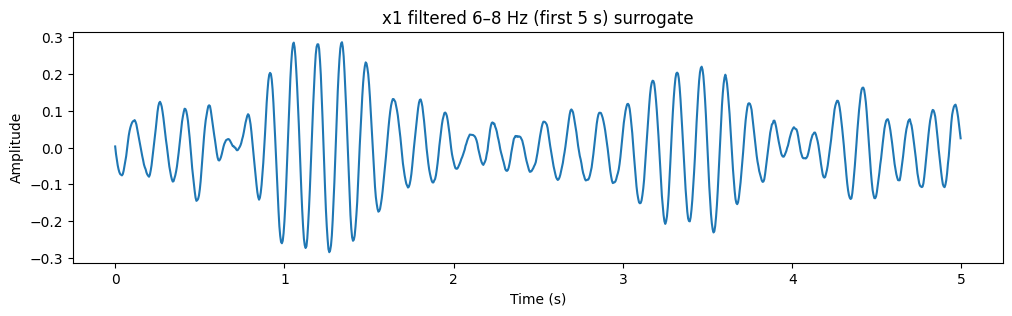

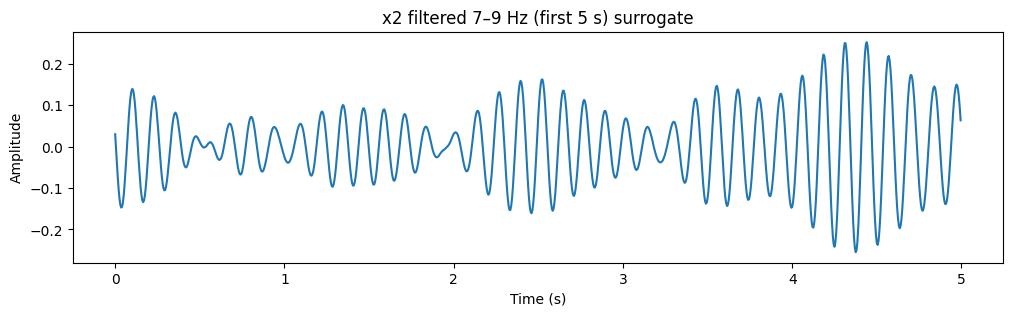

In [ ]:
x1_68_surrogate = time_domain_surrogate_good2(x1_68)
x2_79_surrogate = time_domain_surrogate_good2(x2_79)

plt.figure(figsize=(12,3))
plt.plot(t[:m], x1_68_surrogate[:m]); plt.title('x1 filtered 6–8 Hz (first 5 s) surrogate')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()

plt.figure(figsize=(12,3))
plt.plot(t[:m], x2_79_surrogate[:m]); plt.title('x2 filtered 7–9 Hz (first 5 s) surrogate')
plt.xlabel('Time (s)'); plt.ylabel('Amplitude'); plt.show()

phase_x1_68_sur = np.angle(hilbert(x1_68_surrogate))
phase_x2_79_sur = np.angle(hilbert(x2_79_surrogate))

In [ ]:
x1_68_hilbert_sur = hilbert_domain_surrogate(x1_68, seed=42)
x2_79_hilbert_sur = hilbert_domain_surrogate(x2_79, seed=42)

phase_x1_68_hilbert = np.angle(hilbert(x1_68_hilbert_sur))
phase_x2_79_hilbert = np.angle(hilbert(x2_79_hilbert_sur))

In [ ]:
mpc_original_filter = compute_mpc(np.angle(hilbert(x1_68)), np.angle(hilbert(x2_79)))
mpc_time_sur_filter = compute_mpc(phase_x1_68_sur, phase_x2_79_sur)
#mpc_hilbert_sur_filter = compute_mpc(phase_x1_68_hilbert, phase_x2_79_hilbert)

print(f"MPC Original: {mpc_original_filter:.4f}")
print(f"MPC Time-domain Surrogate: {mpc_time_sur_filter:.4f}")
#print(f"MPC Hilbert-domain Surrogate: {mpc_hilbert_sur_filter:.4f}")


MPC Original: 0.3183
MPC Time-domain Surrogate: 0.2239


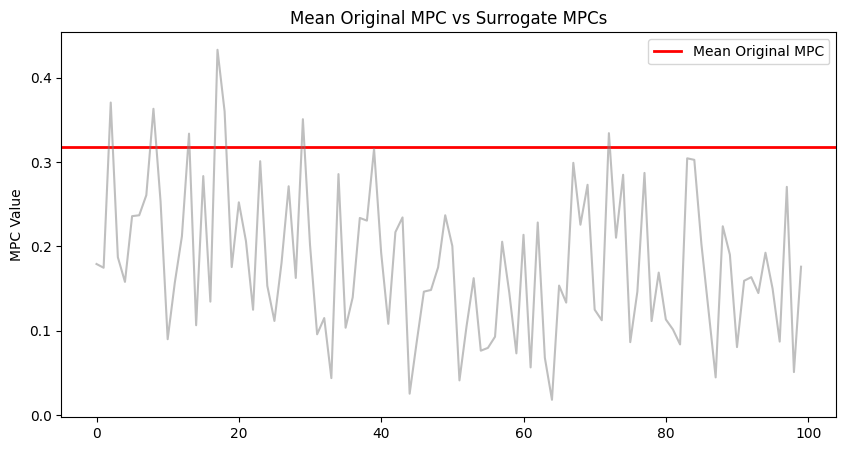

In [ ]:
surrogates = []

for i in range(100):
    x1_68_surrogate = time_domain_surrogate_good2(x1_68)
    x2_79_surrogate = time_domain_surrogate_good2(x2_79)
    mpc_time_sur_filter = compute_mpc(
        np.angle(hilbert(x1_68_surrogate)),
        np.angle(hilbert(x2_79_surrogate))
    )
    #print(mpc_time_sur_filter)
    surrogates.append(mpc_time_sur_filter)

surrogates = np.array(surrogates)

plt.figure(figsize=(10,5))
mean_mpc = np.mean(mpc_original_filter.flatten())
plt.axhline(mean_mpc, label='Mean Original MPC', color='red', linewidth=2, linestyle='-')
plt.plot(surrogates.T, color='gray', alpha=0.5)
plt.ylabel('MPC Value')
plt.title('Mean Original MPC vs Surrogate MPCs')
plt.legend()
plt.show()